
# Credit Scoring

**Цель проекта** - предсказать дефолт клиента 

**Задачи**:

 - Подготовить набор данных для обучения модели
 - Потренировать работу с pandas на реальных данных
 - Попрактиковаться в предобработке различных данных, в частности с пропущенными данными (Nan) и с различными видами кодирования признаков
 - Попрактиковаться в Feature Engineering
 - Попрактиковаться в построении модели, в определении оптимальных гиперпарамтров для нее
 - Попрактиковаться в работе с несбалансированной выборкой и методами работы с ней

# 1. import

In [1]:
from pandas import Series
import pandas as pd
import numpy as np
import seaborn as sns
import os
import math

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, cohen_kappa_score
from sklearn.metrics import precision_recall_curve

from itertools import combinations
from scipy.stats import ttest_ind

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#!pip install --user imblearn
#!pip install --user -U scikit-learn
#!pip install --user scikit-learn==0.24.1

In [3]:
# Уберем Warnings из отображения
import warnings; warnings.simplefilter('ignore')

# Поправим отображение дасетов
pd.set_option('display.max_columns', None)

In [4]:
# этот блок закомментирован так как используется только на kaggle
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
PATH_to_file = './sf-dst-scoring/'

./.DS_Store
./README.md
./requirements.txt
./sf-credit-scoring-emelyanovan.ipynb
./submission.csv
./utils_module28072020.py
./.ipynb_checkpoints/[SF-DST] Credit Scoring (EmelyanovAN)-checkpoint.ipynb
./.ipynb_checkpoints/sf-credit-scoring-emelyanovan-checkpoint.ipynb
./sf-dst-scoring/sample_submission.csv
./sf-dst-scoring/test.csv
./sf-dst-scoring/train.csv


In [5]:
RANDOM_SEED = 42
!pip freeze > requirements.txt
CURRENT_DATE = pd.to_datetime('04/04/2021')

# 2. Data

In [6]:
# Загрузим данные обучающей и тестовой выборок 
data_train = pd.read_csv(PATH_to_file + 'train.csv')
data_test = pd.read_csv(PATH_to_file + 'test.csv')

# Посмотрим на загруженные данные
print('Размерность тренировочного датасета: ', data_train.shape)
display(data_train.head(2))
print('Размерность тестового датасета: ', data_test.shape)
display(data_test.head(2))

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N


In [7]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
# Необходимо помнить, что объединение датасетов является потенциальной опасностью для даталиков
data_train['train'] = 1 # помечаем где у нас трейн
data_test['train'] = 0 # помечаем где у нас тест

data_test['default'] = 0
data = data_train.append(data_test, sort=False).reset_index(drop=True) # объединяем

# Посмотрим на общий датасет
print('Размерность тестового датасета: ', data.shape)
display(data.head(2))

Размерность тестового датасета:  (110148, 20)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1


# 3. Cleaning and Prepping Data
## Определим вспомогательные функции

In [8]:
def data_full_info(data, full=True, short=False):
    '''Функция для вывода общей информации по датасету.
    data - набор исходных данных
    full - флаг вывода информации для количественных признаков
    short - флаг вывода информации из первых трех строк датасета
    
    Функция для выводит общую информацию по датасету.
    
    Если установлен флаг short, то отобразить первые три строки из датасета.
    В ином случае - не отображать.
    
    
    Если установлен флаг full, то отобразить информацию для количественных признаков.
    В ином случае - не отображать.
    '''
        
    list_of_names = list(data.columns)
    temp_dict = {}
    temp_dict['имя признака'] = list_of_names
    temp_dict['тип'] = data.dtypes
    temp_dict['# значений'] = data.describe(include='all').loc['count'].astype(int)
    temp_dict['# пропусков(NaN)'] = data.isnull().sum().values 
    temp_dict['# уникальных'] = data.nunique().values
    
    if not short:
        temp_dict['в первой строке'] =data.loc[0].values
        temp_dict['во второй строке'] = data.loc[1].values
        temp_dict['в третьей строке'] = data.loc[2].values
        
    if full :
        temp_dict['минимум'] = data.describe(include='all').loc['min']
        temp_dict['среднее'] = data.describe(include='all').loc['mean']
        temp_dict['макс'] = data.describe(include='all').loc['max']
        temp_dict['медиана'] = data.describe(include='all').loc['50%']
        
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
    display(temp_df.T)

    return


In [9]:
def column_info(data: pd.DataFrame, column: str) -> None:
    '''Функция для вывода информации для номинативных признаков.
    data - набор исходных данных
    column - наименование признака
    
    Функция производит расчет ключевых значений номинативного признака и выводит их в stdout.
    
    '''
    
    n = 10 # Параметр для оценки наиболее часто встречающихся значений
    print(f'Проведем анализ для переменной {column}')
    
    print('Тип данных: ', data[column].dtype)
    print('Всего значений:', data.shape[0])
    print('Пустых значений:', data.shape[0] - data[column].notnull().sum())
    print(f'Значений, упомянутых более {n} раз:', (data[column].value_counts() > n).sum())
    print('Уникальных значений:', data[column].nunique())
      
    display(pd.DataFrame(data[column].value_counts()).head(10))
    

def plot_column_info(data: pd.DataFrame, column: str) -> None:  
    '''Функция для вывода информации для колличественных переменных.
    data - набор исходных данных
    column - наименование признака
    
    Функция производит расчет ключевых значений колличественного признака.
    Определяет наличие выбросов. Выводит полученные данные в stdout. 
    Риует гистограмму исходных значений и значениий ограниченных границами выбросов IQR.
    
    '''
    
    max_value = data[column].max()
    min_value = data[column].min()
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    lower_limt = perc25 - 1.5*IQR
    upper_limit = perc75 + 1.5*IQR

    if max_value <= upper_limit and min_value >= lower_limt:
        outliers_status = 'Выбросов Нет.'
    else:
        outliers_status = 'Есть выбросы.'

    print('Всего значений:', data.shape[0])
    print('Пустых значений:', data.shape[0] - data[column].notnull().sum())
    
    print('25-й перцентиль: {}, 75-й перцентиль: {}, IQR: {},'.format(perc25, perc75, IQR))
    print(f'Границы значений: [{min_value}, {max_value}],')
    print('Границы выбросов: [{f}, {l}].'.format(f=lower_limt, l=upper_limit))
    print(outliers_status)
    
    plt.rcParams['figure.figsize'] = (10,7)
    
    data[column].loc[data[column].between(lower_limt, upper_limit)].hist(bins=20,
                                                                         range=(min_value, max_value), 
                                                                         label='IQR')

    data[column].hist(alpha=0.5, 
                      bins=20, 
                      range=(min_value, max_value), 
                      label='Исходные значения')

    plt.legend();

In [10]:
def plot_column_info_log(data: pd.DataFrame, column: str) -> None:  
    '''Функция для вывода информации для колличественных переменных.
    data - набор исходных данных
    column - наименование признака
    
    Функция производит расчет ключевых значений колличественного признака.
    Определяет наличие выбросов. Выводит полученные данные в stdout. 
    Риует гистограмму исходных значений, boxplot исходных значений, гистограмму логарифма исходных значений 
    и boxplot для них.
    
    '''
    
    max_value = data[column].max()
    min_value = data[column].min()
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    lower_limt = perc25 - 1.5*IQR
    upper_limit = perc75 + 1.5*IQR
    
    if max_value <= upper_limit and min_value >= lower_limt:
        outliers_status = 'Выбросов Нет.'
    else:
        outliers_status = 'Есть выбросы.'
    
    outliers_num = data.query(f'{column} < {lower_limt} or {column} > {upper_limit}').shape[0]
    
    print('Всего значений:', data.shape[0])
    print('Пустых значений:', data.shape[0] - data[column].notnull().sum())
    
    print('25-й перцентиль: {}, 75-й перцентиль: {}, IQR: {},'.format(perc25, perc75, IQR))
    print(f'Границы значений: [{min_value}, {max_value}],')
    print('Границы выбросов: [{f}, {l}].'.format(f=lower_limt, l=upper_limit))
    print(outliers_status)
    print('Количество выбросов:', outliers_num)
    
    plt.rcParams['figure.figsize'] = (12,4)
    
    ser_iqr = data[column].loc[data[column].between(lower_limt, upper_limit)]
    ser_act = data[column]
    ser_log = data[column].apply(lambda x: math.log(x + 1))
    
    fig = plt.figure()
    st = fig.suptitle(f'Гистограммы и box-plot для признака \'{column}\' и log(\'{column}\')', fontsize='x-large')
    
    ax_1 = fig.add_subplot(1, 4, 1)
    ax_2 = fig.add_subplot(1, 4, 2)
    ax_3 = fig.add_subplot(1, 4, 3)
    ax_4 = fig.add_subplot(1, 4, 4)
    
    ax_1.hist(ser_act, bins=15)
    ax_1.set_title(f'\'{column}\'', loc = 'right', fontsize=10)
    ax_1.spines['top'].set_visible(False)
    ax_1.spines['right'].set_visible(False)
    
    ax_2.boxplot(ser_act)
    ax_2.set_title(f'boxplot of \'{column}\'', loc = 'left', fontsize=10)
    ax_2.spines['top'].set_visible(False)
    ax_2.spines['right'].set_visible(False)
    ax_2.spines['bottom'].set_visible(False)
    ax_2.spines['left'].set_visible(False)
    
    ax_3.hist(ser_log, bins=15)
    ax_3.set_title(f'log(\'{column}\')', loc = 'right', fontsize=10)
    ax_3.spines['top'].set_visible(False)
    ax_3.spines['right'].set_visible(False)
    
    ax_4.boxplot(ser_log)
    ax_4.set_title(f'boxplot of log(\'{column}\')', loc = 'left', fontsize=10)
    ax_4.spines['top'].set_visible(False)
    ax_4.spines['right'].set_visible(False)
    ax_4.spines['bottom'].set_visible(False)
    ax_4.spines['left'].set_visible(False)
    
    
    # shift subplots down:
    st.set_y(0.99)
    fig.subplots_adjust(top=0.85)
    
    plt.legend()
    plt.show();

In [11]:
def replace_nan(data_in: pd.DataFrame, column: str, typ: str, new_value='') -> pd.DataFrame:
    '''Функция возвращает датасет, в котором произведена замена пустых значений признака и добавлен новый
    признак, в котором сохраняется информаця о том, в какой строке было пустое значение
    data_in - набор исходных данных
    column - наименование признака
    typ - тип замены, может принимать значения: 'mode', 'median', 'mean', 'new_value'
    
    Создается новый признак с наименованием (column)_isnan, в котором сохраняется информаця 
    о том, в какой строке пустое значение признака (column)
    В зависимости от типа замены (typ) функция определяет значение, 
    на которое будет производится замена.
    Все значения признака (column) в наборе данных (data_in) заменяются на вычисленное значение.
    Функция возращает откорректированный набор данных, изменений в исходном наборе нет.
    
    '''
    
    data = data_in.copy()
    
    print(f'В новый признак \'{column}_isnan\' охраняем информацию, в каком наблюдении указано NaN')
    data.loc[:, column + '_isnan'] = pd.isna(data[column]).astype('uint8')
    
    if typ == 'mode':
        m = data.loc[:, column].mode()[0]
        s = 'самым распространенным значением '
    elif typ == 'median':
        m = data.loc[:, column].median()
        s = 'медианой'
    elif typ == 'mean':
        m = data.loc[:, column].mean()
        s = 'средневзвешенным значением'
    elif typ == 'new_value':
        m = new_value
        s = 'указанным значением'
    else:
        return None
    
    print(f'Заполним пустые значения признака {column} {s} {m}')
    data.loc[:, column] = data[column].fillna(m)
    
    return data

In [12]:
def all_metrics(d_y_true, d_y_pred, d_y_pred_prob):
        
    temp_dict = {}
    temp1 = accuracy_score(d_y_true, d_y_pred)
    temp_dict['accuracy'] = [temp1, '(TP+TN)/(P+N)']

    temp1 = balanced_accuracy_score(d_y_true, d_y_pred)
    temp_dict['balanced accuracy'] = [temp1, 'сбалансированная accuracy']
    
    temp1 = precision_score(d_y_true, d_y_pred)
    temp_dict['precision'] = [temp1, 'точность = TP/(TP+FP)']
    
    temp1 = recall_score(d_y_true, d_y_pred)
    temp_dict['recall'] = [temp1, 'полнота = TP/P']
    
    temp1 = f1_score(d_y_true, d_y_pred)
    temp_dict['f1_score'] = [temp1, 'среднее гармоническое точности и полноты']
    
    temp1 = roc_auc_score(d_y_true, d_y_pred_prob)
    temp_dict['roc_auc'] = [temp1, 'Area Under Curve - Receiver Operating Characteristic']    
    
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index', columns=['Значение', 'Описание'])
    display(temp_df)

    return


def model_coef(d_columns, d_model_coef_0):

    temp_dict = {}
    temp_dict['имя признака'] = d_columns
    temp_dict['коэффициент модели'] = d_model_coef_0
    temp_dict['модуль коэф'] = abs(temp_dict['коэффициент модели'])
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='columns')
    temp_df = temp_df.sort_values(by='модуль коэф', ascending=False)
    temp_df.reset_index(drop=True,inplace=True)
    
    return temp_df.loc[:,['имя признака','коэффициент модели']]

In [13]:
def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)
    
    
def vis_cross_val_score(d_name_metric, d_vec, d_value_metric, d_my_font_scale):
    num_folds = len(d_vec['train_score'])
    avg_metric_train, std_metric_train = d_vec['train_score'].mean(), d_vec['train_score'].std()
    avg_metric_test, std_metric_test = d_vec['test_score'].mean(), d_vec['test_score'].std()

    plt.style.use('seaborn-paper')
    sns.set(font_scale=d_my_font_scale)
    color_text = plt.get_cmap('PuBu')(0.85)

    plt.figure(figsize=(12, 6))
    plt.plot(d_vec['train_score'], label='тренировочные значения', marker='.', color= 'darkblue')
    plt.plot([0,num_folds-1], [avg_metric_train, avg_metric_train], color='blue', label='среднее трен. значений ', marker='.', lw=2, ls = '--')

    plt.plot(d_vec['test_score'], label='тестовые значения', marker='.', color= 'red')
    plt.plot([0,num_folds-1], [avg_metric_test, avg_metric_test], color='lightcoral', label='среднее тест. значений ', marker='.', lw=2, ls = '--')

    plt.plot([0,num_folds-1], [d_value_metric, d_value_metric], color='grey', label='значение метрики до CV', marker='.', lw=3)

    # plt.xlim([1, num_folds])
    y_max = max(avg_metric_train,avg_metric_test) + 1.5*max(std_metric_train,std_metric_test)
    y_min = min(avg_metric_train,avg_metric_test) - 3*max(std_metric_train,std_metric_test)
    plt.ylim([y_min, y_max])
    plt.xlabel('номер фолда', fontsize=15, color = color_text)
    plt.ylabel(d_name_metric, fontsize=15, color = color_text)
    plt.title(f'Кросс-валидация по метрике {d_name_metric} на {num_folds} фолдах', color = color_text, fontsize=17)
    plt.legend(loc="lower right", fontsize=11)
    y_min_text = y_min +0.5*max(std_metric_train,std_metric_test)
    plt.text(0, y_min_text, f'{d_name_metric} на трейне = {round(avg_metric_train,3)} +/- {round(std_metric_train,3)} \n{d_name_metric} на тесте    = {round(avg_metric_test,3)} +/- {round(std_metric_test,3)} \n{d_name_metric} до CV        = {round(d_value_metric,3)}', fontsize = 15)
    plt.show()
    return


In [14]:
# Класс-помощник для красивого отображения данных о модели. Взял у https://www.kaggle.com/ekalachev
class ModelInspector():
    def __init__(self, model, X, y):
        self.model = model
        self.X = X
        self.y = y

    def _plot_confusion_matrix(self, y_pred, ax):
        tn, fp, fn, tp = confusion_matrix(self.y, y_pred).ravel()

        matrix = np.eye(2)
        matrix_annot = np.array([[f'TP\n{tp}', f'FP\n{fp}'], [f'FN\n{fn}', f'TN\n{tn}']])

        sns.heatmap(matrix, annot=matrix_annot, annot_kws={"size": 20}, fmt='', cmap='Greens', cbar=False,
                    xticklabels=['', 'Good client'], yticklabels=['Bad client', ''], ax=ax)

    def _plot_metrics(self, y_pred, roc_auc, ax):
        matrix = np.array([[1, 0, 1, 0, 1]]).T

        matrix_annot = np.array([[
            f'ROC AUC: {roc_auc:.4f}',
            f'Balanced accuracy: {balanced_accuracy_score(self.y, y_pred):.3f}',
            f'F1-score: {f1_score(self.y, y_pred):.3f}',
            f'Precision score: {precision_score(self.y, y_pred):.3f}',
            f'Recall score: {recall_score(self.y, y_pred):.3f}'
        ]]).T

        sns.heatmap(matrix, annot=matrix_annot, fmt='', cbar=False, yticklabels=[],
                    xticklabels=[], annot_kws={'size': 16, 'ha': 'center'}, cmap='GnBu', ax=ax)

    def _plot_logistic_regression(self, probs, ax):
        fpr, tpr, threshold = roc_curve(self.y, probs)

        ax.plot([0, 1], label='Baseline', linestyle='--')
        ax.plot(fpr, tpr, label='Regression')
        ax.set_ylabel('True Positive Rate')
        ax.set_xlabel('False Positive Rate')
        ax.legend(loc='lower right')

    def inspect(self, size=5):
        y_pred = self.model.predict(self.X)
        probs = self.model.predict_proba(self.X)[:, 1]
        roc_auc = roc_auc_score(self.y, probs)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3*size, size))

        fig.suptitle(f'Model inspection. ROC AUC: {roc_auc:.4f}', fontsize=20)

        ax1.set_title('Logistic Regression')
        ax2.set_title('Confusion matrix')
        ax3.set_title('Metrics')

        # Plot logistic regression
        self._plot_logistic_regression(probs, ax1)

        # Plot confusion matrix
        self._plot_confusion_matrix(y_pred, ax2)

        # plot metrics
        self._plot_metrics(y_pred, roc_auc, ax3)

        plt.show()

In [15]:
def get_stat_dif(data: pd.DataFrame, column: str, target: str) -> bool:
    '''Функция определяет, есть ли статистически значимые различия для признака.
    data - набор исходных данных
    column - наименование признака
    target - наименование целевого признака
    
    Функция проверяет, есть ли статистическая разница в распределении целевого признака (target)
    по номинативному признаку (column) в наборе данных (data). 
    Проверка осуществляется с помощью теста Стьюдента. 
    Проверяется нулевая гипотеза о том, что распределения целевого признака (target)
    по различным парам значений номинативного признака (column) неразличимы.
    Пары определяются из различных комбинаций n самых часто встречающихся занчений признака (column).
    Если различия найдены, то информация об этом выводится в stdout.
    
    '''
    
    n = 10 # Параметр для оценки наиболее часто встречающихся значений
    cols = data.loc[:, column].value_counts().index[:n]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], target], 
                     data.loc[data.loc[:, column] == comb[1], target]).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для признака', column)
            return True
    
    return False

## Проведем предварительный анализ данных

In [16]:
# Выведем общую информацию по датасету
data_full_info(data, short=True)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,минимум,среднее,макс,медиана
0,client_id,int64,110148,0,110148,1,55074.5,110148,55074.5
1,app_date,object,110148,0,120,NaN,NaN,NaN,NaN
2,education,object,109670,478,5,NaN,NaN,NaN,NaN
3,sex,object,110148,0,2,NaN,NaN,NaN,NaN
4,age,int64,110148,0,52,21,39.2494,72,37
5,car,object,110148,0,2,NaN,NaN,NaN,NaN
6,car_type,object,110148,0,2,NaN,NaN,NaN,NaN
7,decline_app_cnt,int64,110148,0,24,0,0.273205,33,0
8,good_work,int64,110148,0,2,0,0.165514,1,0
9,score_bki,float64,110148,0,102618,-3.62459,-1.90454,0.199773,-1.92082


In [17]:
# Посмотрим количество пропусков по признаку education
N = data.shape[0]
n = data_train['education'].isna().sum()
m = data_test['education'].isna().sum()

print(f'Всего пропусков - {n+m}, в обучающей выборке - {n} ({round(n*100/N, 2)}%), в тестовой - {m} ({round(m*100/N, 2)}%)')

Всего пропусков - 478, в обучающей выборке - 307 (0.28%), в тестовой - 171 (0.16%)


**Резюме** по предварительному анализу: в тренировочной выборке 73799 клиентов, в тестовой - 36349. Всего данные о 110148 клиентах. Всего 20 признаков, из них 1 признак целевой - **default** и 1 искуственно добавленный признак тренировочной части датасета - **train**. Также присутствует 1 уникальный числовой признак **client_id**, который не несет полезной информации для нашей будущей модели. Всего пропусков - 478, в обучающей выборке - 307 (0.28%), в тестовой - 171 (0.16%), все пропуски в переменной education. 

Описания полей датасета:

 - **client_id** - идентификатор клиента
 - **app_date** - дата подачи заявки
 - **education** - уровень образования
 - **sex** - пол заёмщика
 - **age** - возраст заёмщика
 - **car** - флаг наличия автомобиля
 - **car_type** - флаг автомобиля-иномарки
 - **decline_app_cnt** - количество отказанных прошлых заявок
 - **good_work** - флаг наличия «хорошей» работы
 - **score_bki** - скоринговый балл по данным из БКИ
 - **bki_request_cnt** - количество запросов в БКИ
 - **region_rating** - рейтинг региона
 - **home_address** - категоризатор домашнего адреса
 - **work_address** - категоризатор рабочего адреса
 - **income** - доход заёмщика
 - **sna** - связь заемщика с клиентами банка
 - **first_time** - давность наличия информации о заемщике
 - **foreign_passport** - наличие загранпаспорта
 - **default** - наличие дефолта
 - **train** - вспомогательный признак для определения обучающей и тестовой выборок

## Посмотрим на признаки более внимательно

Расспределим признаки по разым спискам:
 - **Временны'е признаки (1)**
  * 'app_date' - тип object, но исходя из описания признака отнесем во временным признаки
 - **Бинарные признаки (5 + 2 = 7)**
  * 'sex', 'car', 'car_type', 'foreign_passport' тип object + 2 значения, добавим данные признаки к бинарным
  * 'good_work' тип int64, но принимает одно из двух значений, добавим данный признак к бинарным
  * 'default' - целевой, 'train' - вспомогательный. Их не включаем в списки.
 - **Категориальные признаки (6)**
  * 'education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time' - тип int64, принимает от 3 до 7 значений, добавим к категориальны
 - **Колличественные признаки (5 + 1 = 6)**
  * 'age','decline_app_cnt','score_bki','bki_request_cnt','income' тип int64, принимает много значений, доавим к колчественным признакам
  * 'client_id' уникальный признак, не включаем в списки

In [18]:
# Временны'е признаки 
time_cols = ['app_date']

# Бинарные признаки 
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# Категориальные признаки
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']

# Колличественные признаки 
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income']

## Проведем анализ по каждому признаку

### Посмотрим на целевой признак 'default'

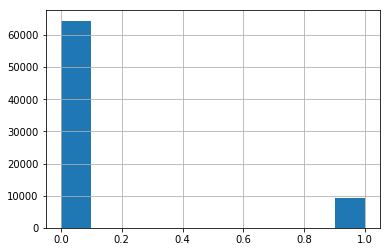

In [19]:
data.query('train == 1')['default'].hist()

In [20]:
data.query('train == 1')['default'].value_counts(normalize=True)

0    0.873006
1    0.126994
Name: default, dtype: float64

**Резюме** Целевой признак принимает значение 1 в 12.7% случаях. Следоватьно обучающая выборка несбалансирована. Данный факт необходимо будет учесть при выборе метрики качества построения модели.

### Бинарные признаки.

In [21]:
# Выведем информацию по бинарным признакам
data_full_info(data[bin_cols], full=False, short=False)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,в первой строке,во второй строке,в третьей строке
0,sex,object,110148,0,2,M,F,M
1,car,object,110148,0,2,Y,N,Y
2,car_type,object,110148,0,2,Y,N,N
3,good_work,int64,110148,0,2,0,0,0
4,foreign_passport,object,110148,0,2,N,N,Y


Пропусков нет. Часть признаков принимает значения типа object. Переформатируем так, чтобы они принимали значения 1 или 0.

In [22]:
# Выносим в блок предобработки

# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    data.loc[:, column] = label_encoder.fit_transform(data[column])

In [23]:
# Проверим внесенные изменения
data_full_info(data[bin_cols], full=False, short=False)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,в первой строке,во второй строке,в третьей строке
0,sex,int64,110148,0,2,1,0,1
1,car,int64,110148,0,2,1,0,1
2,car_type,int64,110148,0,2,1,0,0
3,good_work,int64,110148,0,2,0,0,0
4,foreign_passport,int64,110148,0,2,0,0,1


**Резюме:** Теперь с бинарными признаками все хорошо.

### Категориальные признаки. 

In [24]:
# Выведем информацию по категориальным признакам
data_full_info(data[cat_cols], full=False, short=False)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,в первой строке,во второй строке,в третьей строке
0,education,object,109670,478,5,SCH,SCH,SCH
1,region_rating,int64,110148,0,7,50,50,80
2,home_address,int64,110148,0,3,1,2,1
3,work_address,int64,110148,0,3,2,3,2
4,sna,int64,110148,0,4,4,4,1
5,first_time,int64,110148,0,4,1,1,4


Есть **проблемы** с признаком **'education'**:

In [25]:
column_info(data, 'education')

Проведем анализ для переменной education
Тип данных:  object
Всего значений: 110148
Пустых значений: 478
Значений, упомянутых более 10 раз: 5
Уникальных значений: 5


,education
SCH,57998
GRD,34768
UGR,14748
PGR,1865
ACD,291


In [26]:
# Выносим в блок предобработки

# Есть пустые значения. Заполняем пустые значения самым распространенным значением
data = replace_nan(data, 'education', 'mode')

В новый признак 'education_isnan' охраняем информацию, в каком наблюдении указано NaN
Заполним пустые значения признака education самым распространенным значением  SCH


In [27]:
# Выносим в блок предобработки

# Добавим новый признак 'education_isnan' к бинарным
bin_cols.append('education_isnan')

# Преобразуем education в целочисленный формат. 
edu = {'SCH' : 1, 'UGR' : 2, 'GRD' : 3, 'PGR' : 4, 'ACD' : 5}
data.loc[:, 'education'] = data['education'].map(edu)

In [28]:
# Введем бинарный признак наличия выcшего образования
#data.loc[:, 'high_edu'] = data['education'].apply(lambda x: 1 if x >= 3 else 0)  
#bin_cols.append('high_edu')

In [29]:
# Введем количественный признак среднее значение дефолтов по региону
# default_mean = dict(data.query('train == 1').groupby('region_rating')['default'].mean())
# data.loc[:, 'region_default_mean'] = data['region_rating'].map(default_mean)
# num_cols.append('region_default_mean')

In [30]:
# Выведем информацию после изменений
data_full_info(data[cat_cols + bin_cols], full=False, short=False)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,в первой строке,во второй строке,в третьей строке
0,education,int64,110148,0,5,1,1,1
1,region_rating,int64,110148,0,7,50,50,80
2,home_address,int64,110148,0,3,1,2,1
3,work_address,int64,110148,0,3,2,3,2
4,sna,int64,110148,0,4,4,4,1
5,first_time,int64,110148,0,4,1,1,4
6,sex,int64,110148,0,2,1,0,1
7,car,int64,110148,0,2,1,0,1
8,car_type,int64,110148,0,2,1,0,0
9,good_work,int64,110148,0,2,0,0,0


**Резюме:** Теперь с категориальными признаками все хорошо. В дальнейшем останется только применить подход One-Hot Encoding для этих признаков.

### Количественные признаки. 

#### 1. Признак 'age'

No handles with labels found to put in legend.


Всего значений: 110148
Пустых значений: 0
25-й перцентиль: 30.0, 75-й перцентиль: 48.0, IQR: 18.0,
Границы значений: [21, 72],
Границы выбросов: [3.0, 75.0].
Выбросов Нет.
Количество выбросов: 0


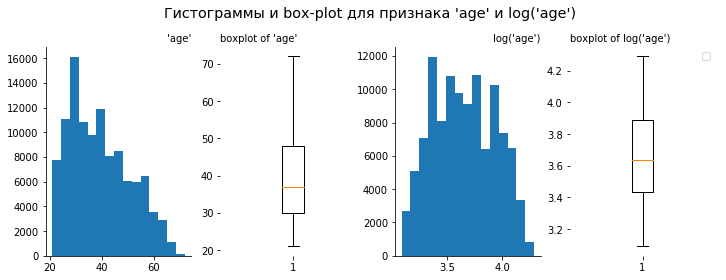

In [31]:
plot_column_info_log(data, 'age')

In [32]:
# Выносим в блок предобработки

# Возьмем логарифм от признака
data.loc[:, 'age'] = np.log(data['age'] + 1)

**Резюме - Age**: Распределение логнормальное , выбросов по квартилям нет. Взяли логарифм от признака

#### 2. Признак 'decline_app_cnt'

No handles with labels found to put in legend.


Всего значений: 110148
Пустых значений: 0
25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,
Границы значений: [0, 33],
Границы выбросов: [0.0, 0.0].
Есть выбросы.
Количество выбросов: 18677


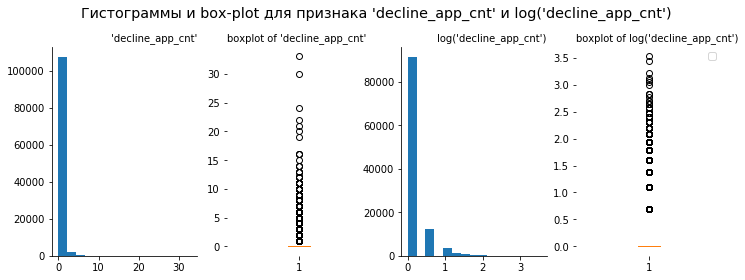

In [33]:
plot_column_info_log(data, 'decline_app_cnt')

In [34]:
data['decline_app_cnt'].value_counts(normalize=True)

0     0.830437
1     0.113484
2     0.032883
3     0.012392
4     0.005502
5     0.002315
6     0.001416
7     0.000527
8     0.000336
9     0.000263
10    0.000145
11    0.000091
12    0.000045
13    0.000036
14    0.000027
16    0.000027
30    0.000009
15    0.000009
19    0.000009
20    0.000009
21    0.000009
22    0.000009
24    0.000009
33    0.000009
Name: decline_app_cnt, dtype: float64

In [35]:
# Выносим в блок предобработки

# Добавим новый признак для сохранения информации у каких клиентов decline_app_cnt > 3
index = data['decline_app_cnt'] > 3
data.loc[:, 'decline_app_cnt_more_then_3'] = index.astype('int8')
bin_cols.append('decline_app_cnt_more_then_3')

# Для всех клиентов с decline_app_cnt > 3, установим decline_app_cnt = 3
data.loc[index, 'decline_app_cnt'] = 3

In [36]:
data['decline_app_cnt'].value_counts(normalize=True)

0    0.830437
1    0.113484
2    0.032883
3    0.023196
Name: decline_app_cnt, dtype: float64

No handles with labels found to put in legend.


Всего значений: 110148
Пустых значений: 0
25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,
Границы значений: [0, 3],
Границы выбросов: [0.0, 0.0].
Есть выбросы.
Количество выбросов: 18677


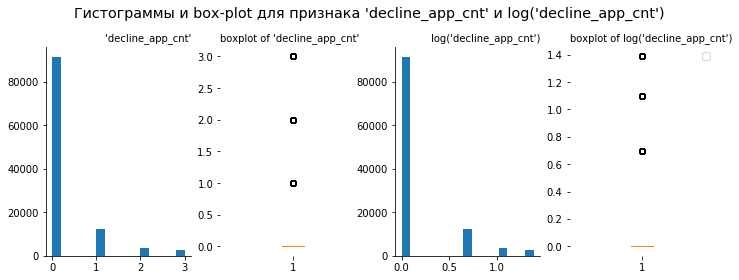

In [37]:
plot_column_info_log(data, 'decline_app_cnt')

Логарифм от признака брать не имеет смысла. Возможно, есть смысл классифицировать признак 'decline_app_cnt' не как количественный, а как категориальный.

In [38]:
# Классифицируем признак 'decline_app_cnt' не как количественный, а как категориальный.
cat_cols.append('decline_app_cnt')
num_cols.remove('decline_app_cnt')

**Резюме - decline_app_cnt**: Выбросы по квартилям есть, но они имеют право на существование. Для всех клиентов с decline_app_cnt > 3, установили decline_app_cnt = 3. Информацию о клиентах с decline_app_cnt > 3 сохранили в отдельный бинарный признак. Логарифм от признака брать не имеет смысла.

#### 3. Признак 'bki_request_cnt'

No handles with labels found to put in legend.


Всего значений: 110148
Пустых значений: 0
25-й перцентиль: 0.0, 75-й перцентиль: 3.0, IQR: 3.0,
Границы значений: [0, 53],
Границы выбросов: [-4.5, 7.5].
Есть выбросы.
Количество выбросов: 2636


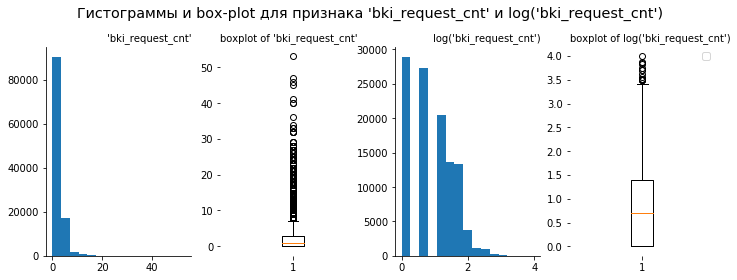

In [39]:
plot_column_info_log(data, 'bki_request_cnt')

In [40]:
# Выносим в блок предобработки

# Возьмем логарифм от признака
data.loc[:, 'bki_request_cnt'] = np.log(data['bki_request_cnt'] + 1)

**Резюме - bki_request_cnt**: Взяли логарифм от признака. Есть выбросы, но они теоритечески возможны для данного признака, удалять не стали.

#### 4. Признак 'income'

No handles with labels found to put in legend.


Всего значений: 110148
Пустых значений: 0
25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0,
Границы значений: [1000, 1000000],
Границы выбросов: [-22000.0, 90000.0].
Есть выбросы.
Количество выбросов: 7000


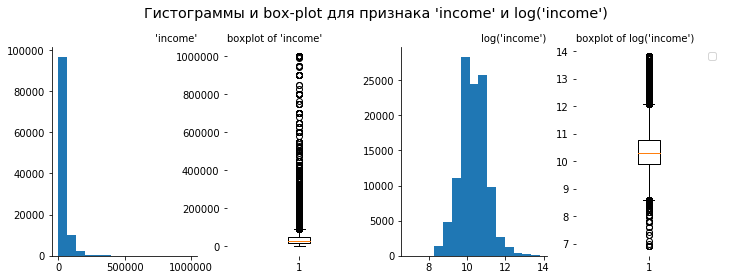

In [41]:
plot_column_info_log(data, 'income')

In [42]:
# Выносим в блок предобработки

# Возьмем логарифм от признака
data.loc[:, 'income'] = np.log(data['income'] + 1)

**Резюме - income**: Распределение логнормальное - взяли логарифм от признака, после логарифмирования выбросы остались, удалять их пока не будем. Построим модель, а потом вернемся к этому вопросу при необходимости.

#### 5. Признак 'score_bki'

Всего значений: 110148
Пустых значений: 0
25-й перцентиль: -2.2604336700000003, 75-й перцентиль: -1.5678881525, IQR: 0.6925455175000004,
Границы значений: [-3.62458632, 0.19977285],
Границы выбросов: [-3.299251946250001, -0.5290698762499992].
Есть выбросы.


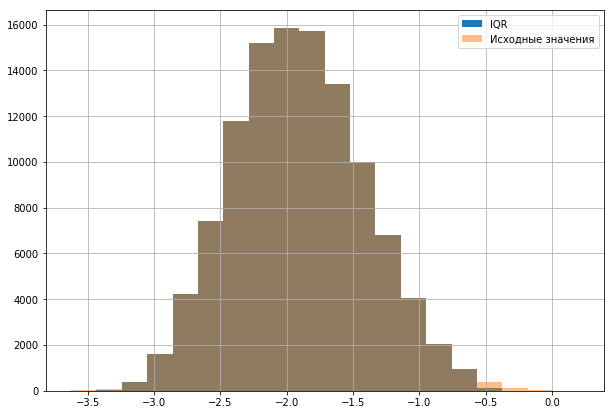

In [43]:
plot_column_info(data, 'score_bki')

**Резюме - score_bki**: Распределение нормальное. Выбросов не много, не стали удалять

### Временные признаки. 

#### 1. Признак 'app_date'

In [44]:
# Выносим в блок предобработки

# Преобразуем формат признака
data.loc[:, 'app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')

In [45]:
# Выносим в блок предобработки

#  Добавим три новых признака: количество дней с первого дня учета клиентов, номер недели и номер месяца
data.loc[:, 'app_date_day'] = (data['app_date'] - data['app_date'].min()).dt.days
data.loc[:, 'app_date_week'] = data['app_date'].dt.week
data.loc[:, 'app_date_month'] = data['app_date'].dt.month

num_cols += ['app_date_day', 'app_date_week', 'app_date_month']

Всего значений: 110148
Пустых значений: 0
25-й перцентиль: 33.0, 75-й перцентиль: 89.0, IQR: 56.0,
Границы значений: [0, 119],
Границы выбросов: [-51.0, 173.0].
Выбросов Нет.


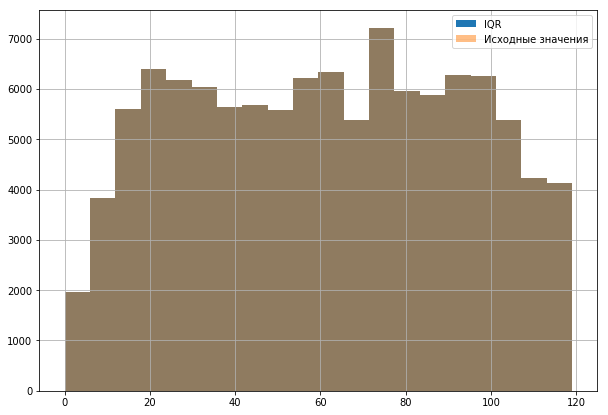

In [46]:
plot_column_info(data, 'app_date_day')

Всего значений: 110148
Пустых значений: 0
25-й перцентиль: 6.0, 75-й перцентиль: 14.0, IQR: 8.0,
Границы значений: [1, 18],
Границы выбросов: [-6.0, 26.0].
Выбросов Нет.


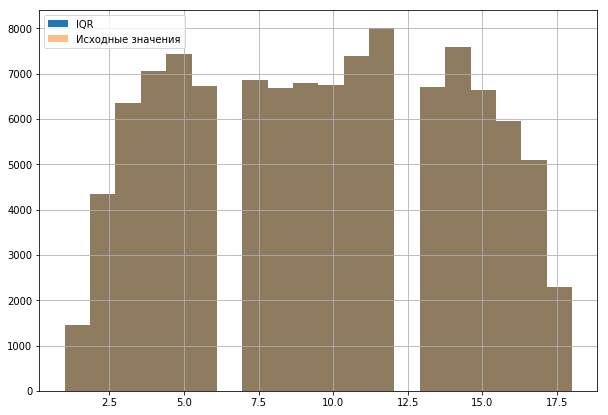

In [47]:
plot_column_info(data, 'app_date_week')

Всего значений: 110148
Пустых значений: 0
25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,
Границы значений: [1, 4],
Границы выбросов: [0.5, 4.5].
Выбросов Нет.


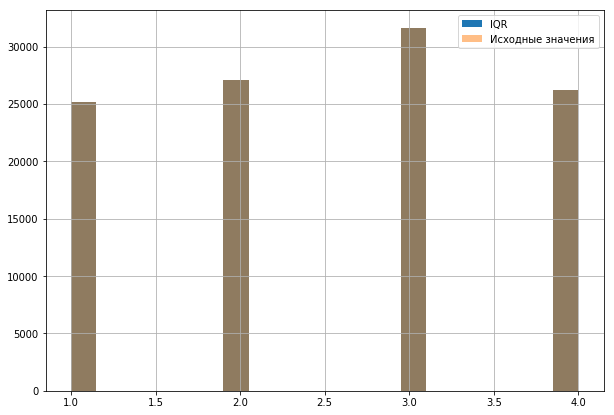

In [48]:
plot_column_info(data, 'app_date_month')

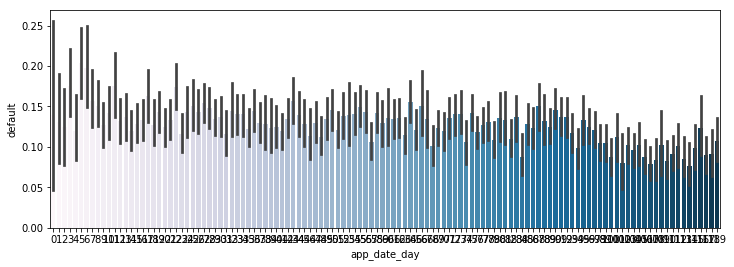

In [49]:
plt.subplots(figsize=(12, 4))
sns.barplot(data=data.query('train == 1'), x='app_date_day', y='default', palette="PuBu");

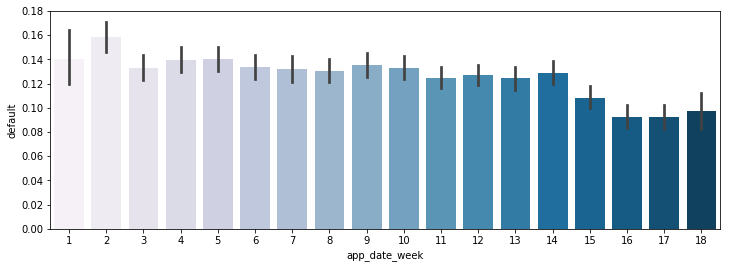

In [50]:
plt.subplots(figsize=(12, 4))
sns.barplot(data=data.query('train == 1'), x='app_date_week', y='default', palette="PuBu");

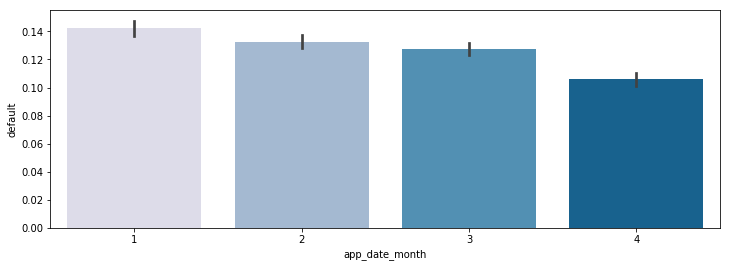

In [51]:
plt.subplots(figsize=(12, 4))
sns.barplot(data=data.query('train == 1'), x='app_date_month', y='default', palette="PuBu");

In [52]:
# Добавим биноминальный признак, является ли дата выходным днем или нет
data.loc[:, 'weekend'] = data['app_date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
bin_cols.append('weekend')

**Резюме - app_date_month, app_date_week, app_date_month**:  По всем трем признакам наблюдается тренд на снижение случаев дефолта. Что в целом объяснимо желанием компании снижения количества таких случаем и тем, что принимаются для этого некоторые действия. Отнесем пока все три признака к Количественным. Далее посмотрим на них при корреляционном анализе, скорее всего они будет сильно скоррелированы и чать из них придется убрать.

## Оценка корреляций

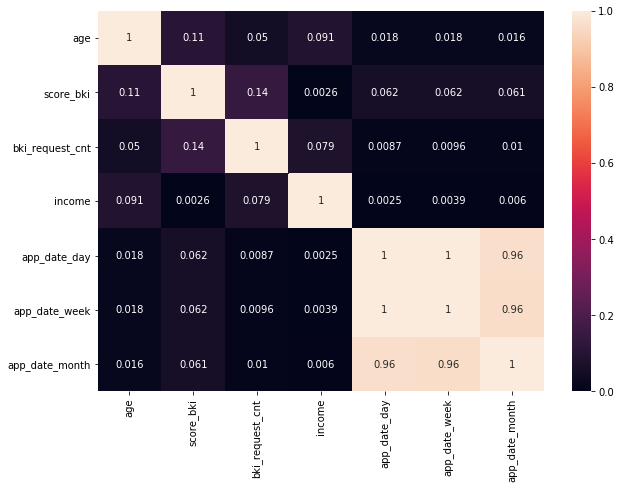

In [53]:
# Оценим корреляцию Пирсона для непрерывных переменных 
plt.figure(figsize = (10,7))
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Как и ожидалось, присутствует сильная корреляция между признаками 'app_date_day', 'app_date_week' и 'app_date_month', надо будет оставить только один признак. Посмотрим на более точные значения корреляций с целевым признаком:

In [54]:
data.query('train == 1')[['app_date_day', 'app_date_week', 'app_date_month', 'default']].corr()

,app_date_day,app_date_week,app_date_month,default
app_date_day,1.000000,0.998271,0.965003,-0.039372
app_date_week,0.998271,1.000000,0.963190,-0.039276
app_date_month,0.965003,0.963190,1.000000,-0.037115
default,-0.039372,-0.039276,-0.037115,1.000000


In [55]:
data.drop(columns=['app_date_week', 'app_date_month'], inplace=True)
num_cols.remove('app_date_week')
num_cols.remove('app_date_month')

**Резюме** - временной признак 'app_date' оставляем как есть. Из его производных признаков 'app_date_day', 'app_date_week', 'app_date_month' оставляем только 'app_date_day'. 

## Посмотрим на значимость колличественных переменных

Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn. 

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

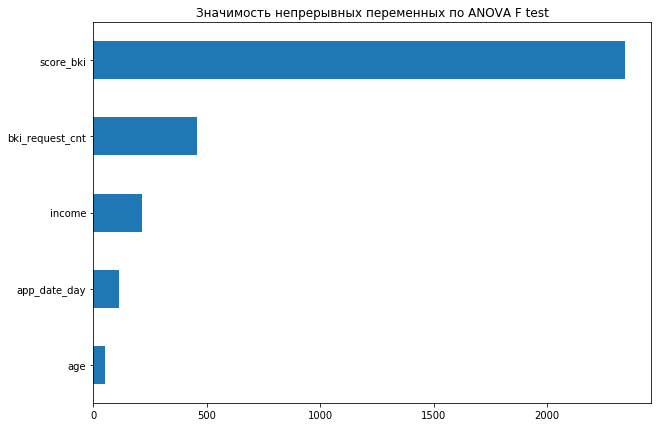

In [56]:
df = data.query('train == 1')
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных по ANOVA F test')

**Резюме** - оценка плательщика БКИ (score_bki) самый значимый показатель по ANOVA F test, потом кол-во отказанных заявок (declain_app_cnt) и в конце возраст (age)

## Посмотрим на значимость категориальных и бинарных переменных

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

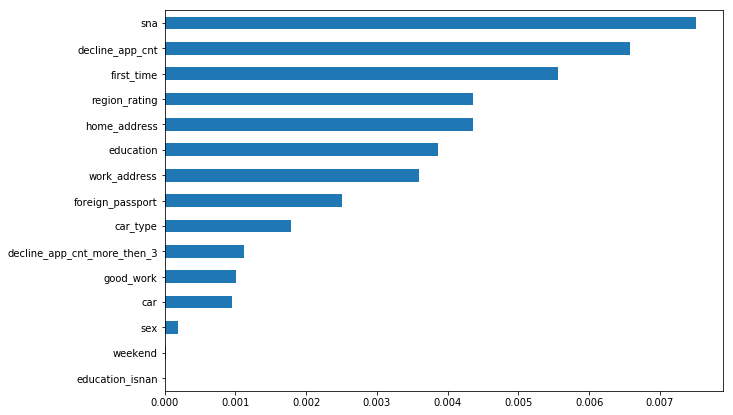

In [57]:
df = data.query('train == 1')
imp_cat = Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

**Резюме:**  Самыми значимыми признаками по Mutual information тесту является связь заемщика с клиентами банка (sna) и давность наличия информации о заемщике (first_time). Самыми незаничимыми - в конце пол (sex) и факт, того что образование не указано в данных о клиенте (education_isnan).

In [58]:
nom_cols = cat_cols + bin_cols
delete_cols = []

for col in nom_cols:
    if not get_stat_dif(data.query('train == 1'), col, 'default'):
        delete_cols.append(col)
        
print('Признаки на удаление: ', delete_cols)

Найдены статистически значимые различия для признака education
Найдены статистически значимые различия для признака region_rating
Найдены статистически значимые различия для признака home_address
Найдены статистически значимые различия для признака work_address
Найдены статистически значимые различия для признака sna
Найдены статистически значимые различия для признака first_time
Найдены статистически значимые различия для признака decline_app_cnt
Найдены статистически значимые различия для признака sex
Найдены статистически значимые различия для признака car
Найдены статистически значимые различия для признака car_type
Найдены статистически значимые различия для признака good_work
Найдены статистически значимые различия для признака foreign_passport
Найдены статистически значимые различия для признака decline_app_cnt_more_then_3
Признаки на удаление:  ['education_isnan', 'weekend']


In [59]:
# Уберем лишние признаки
data.drop(columns=delete_cols, inplace=True)

for col in delete_cols:
    if col in bin_cols:
        bin_cols.remove(col)
    if col in cat_cols:
        cat_cols.remove(col)

In [60]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,decline_app_cnt_more_then_3,app_date_day
0,25905,2014-02-01,1,1,4.143135,1,1,0,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0,1,0,31
1,63161,2014-03-12,1,0,4.094345,0,0,0,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0,1,0,70
2,25887,2014-02-01,1,1,3.258097,1,0,2,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0,1,0,31
3,16222,2014-01-23,1,0,3.988984,0,0,0,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0,1,0,22
4,101655,2014-04-18,3,1,3.891820,0,0,0,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0,1,0,107


# 3. Data Preprocessing

Перед обучением регрессии необходимо сделать две вещи:
 - Стандартизировать числовые признаки
 - Применить OneHotEncoding подход к категориальным признакам
 - Удалить ненужные признаки
 - Сделать разбиение на тестовую и валидационную выборки

## OneHotEncoding для кактегориальных признаков

In [61]:
# реализуем метод OneHotEncoding через get_dummies
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

In [62]:
data.head(2)

,client_id,app_date,sex,age,car,car_type,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,train,decline_app_cnt_more_then_3,app_date_day,education_1,education_2,education_3,education_4,education_5,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,decline_app_cnt_0,decline_app_cnt_1,decline_app_cnt_2,decline_app_cnt_3
0,25905,2014-02-01,1,4.143135,1,1,0,-2.008753,0.693147,9.798183,0,0,1,0,31,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0
1,63161,2014-03-12,0,4.094345,0,0,0,-1.532276,1.386294,9.852247,0,0,1,0,70,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0


## Стандартизируем числовые переменные:

In [63]:
# Стандартизация числовых переменных
scaler = StandardScaler()

index = data.query('train == 1')[num_cols].index
values_income = data.query('train == 1')[num_cols].values
values_norm = scaler.fit_transform(values_income)
data.loc[index, num_cols] = values_norm

index = data.query('train == 0')[num_cols].index
values_income = data.query('train == 0')[num_cols].values
values_norm = scaler.transform(values_income)
data.loc[index, num_cols] = values_norm

In [64]:
data.head()

,client_id,app_date,sex,age,car,car_type,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,train,decline_app_cnt_more_then_3,app_date_day,education_1,education_2,education_3,education_4,education_5,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,decline_app_cnt_0,decline_app_cnt_1,decline_app_cnt_2,decline_app_cnt_3
0,25905,2014-02-01,1,1.711137,1,1,0,-0.208799,-0.281005,-0.785016,0,0,1,0,-0.935052,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0
1,63161,2014-03-12,0,1.539988,0,0,0,0.747545,0.772607,-0.707526,0,0,1,0,0.279082,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0
2,25887,2014-02-01,1,-1.393439,1,0,0,0.996696,-0.281005,-0.052888,1,0,1,0,-0.935052,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0
3,16222,2014-01-23,0,1.170400,0,0,0,-0.306582,0.335319,-1.627419,0,0,1,0,-1.215237,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0
4,101655,2014-04-18,1,0.829565,0,0,1,1.324697,-0.281005,-0.052888,1,0,1,0,1.430952,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0


## Убираем лишние признаки

In [65]:
# Удалим лишнее 'app_date', 'client_id'

data.drop(['app_date', 'client_id'], axis=1, inplace=True)

## Подготовка выборок

In [66]:
# Разбиваем датасет на тренировочный и тестовый

train_data = data.query('train == 1').drop(['train'], axis=1)
test_data = data.query('train == 0').drop(['train'], axis=1)

X = train_data.drop(['default'], axis=1).values
y = train_data.default.values            

Подготовка признаков для модели завершена.

In [67]:
# Разделим данные для обучения следующим образом:

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

# 4. Model 
## Модель и Оценка качества модели

В качестве модели будем использовать модель логистической регрессии

In [68]:
model = LogisticRegression(random_state=RANDOM_SEED)
model.fit(X_train, y_train)

y_pred = model.predict(X_valid)
y_pred_proba = model.predict_proba(X_valid)[:,1]

Оценим качество модели:

In [69]:
np.array([1, 2]).shape

(2,)

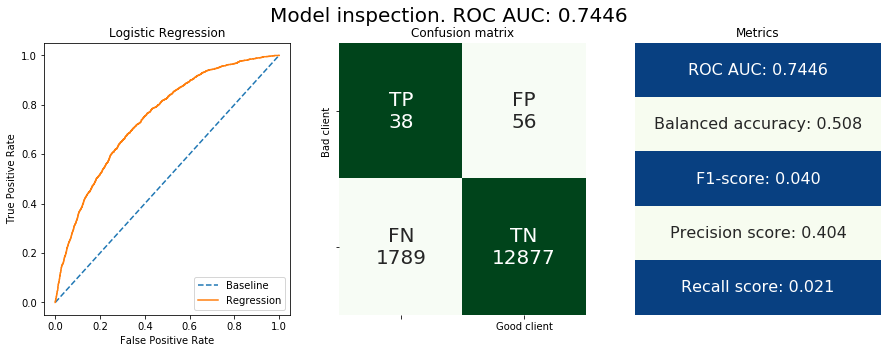

In [70]:
 ModelInspector(model, X_valid, y_valid).inspect()

**Резюме** - Результаты оцениваются по Метрике качества модели - по площади под кривой ROC AUC. В нашей модели мы абсолютно не угадали дефолтных клиентов, тем самым обеспечили себе огромную ошибку второго рода и как следствие колосальный убыток, но ROC-AUC у нас высокий. Благо f1 как-то сигнализирует о том что что-то не впорядке. 

### Кросс-валидация

Посмотрим на метрику качества на различных разбиениях:

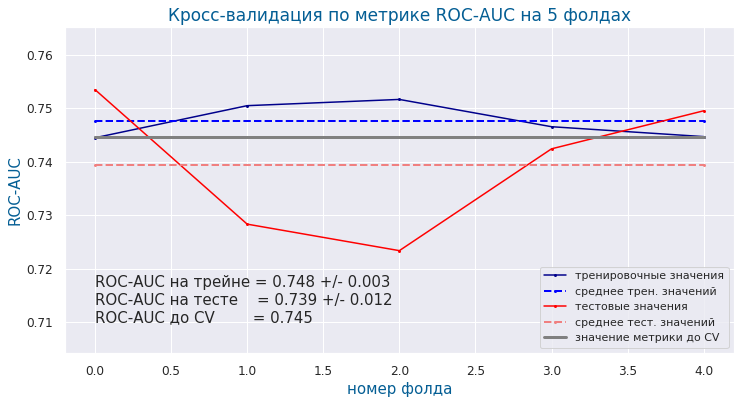

In [71]:
cv_metrics = cross_validate(model, X_valid, y_valid, cv=5, scoring='roc_auc', return_train_score=True)
vis_cross_val_score('ROC-AUC', cv_metrics, 0.744556, 1.1)

**Резюме** - модель, которую мы получили, очень плохая, несмотря на то, что целевая метрика ROC-AUC достаточно высокая (=0.7445).
Потому что:

Из матрицы ошибок видно, что мы почти не угадываем дефолтных клиентов (58 из 1789). Об этом также свидетествует метрика полнота recall = 0.020799, которая собственно описывает этот момент. Таким образом все клиенты попали в ошибку второго рода, а это очень плохо для банка, так как мы будем выдавать кредиты людям которые их не смогут вернуть - риск потерять все деньги.
Но целевая переменная площадь под ROC кривой оказалась не такой уж плохой. 
Кросс валидация показала дисперсию ошибки на тесте 0.014 и так как мы не использовали перемешивания, то можно сказать что модель лучше работает на крайних фолдах, чем на средних. В анализе признака data приводилась аналитика, которая говорила о том что вероятно в середине периода в банке проводилась какая-то акция и порог выдачи кредита снижался. Но мы в своей работе стремились создать надежный алгоритм который снижает ошибку второго рода (снижает потери банка) и достаточно стабильно работает (f1, PRC_AUC) при оптимальных значениях точности, а не гнались за просто высоким результатом на лидерборде.

### Попробуем решить проблему поиском оптимальных значений гипер-параметров для логистической регрессии. 

In [72]:
def find_best_params(X_train, y_train):
    '''Функция для нахождения лучших гиперпараметров для модели.'''
    
    # Добавим типы регуляризации
    penalty = ['l1', 'l2', 'elasticnet']

    # Зададим ограничения для параметра регуляризации
    C = np.logspace(0, 4, 10)

    # Создадим гиперпараметры
    hyperparameters = dict(C=C, penalty=penalty)
    
    param_grid = [
        {'penalty': ['l1'], 'C':[0.1, 1, 10], 'max_iter':[1000],'tol':[1e-5]},
        {'penalty': ['l2'], 'C':[0.1, 1, 10], 'max_iter':[1000],'tol':[1e-5]},
        {'penalty': ['none'], 'max_iter':[1000],'tol':[1e-5]}
    ]

    model = LogisticRegression(random_state=RANDOM_SEED, multi_class='ovr', class_weight='balanced')
    model.fit(X_train, y_train)

    # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
    clf = GridSearchCV(model, hyperparameters, scoring='f1', cv=5, verbose=0)

    best_model = clf.fit(X_train, y_train)

    # View best hyperparameters
    best_params = best_model.best_estimator_.get_params()
    print('Лучшее Penalty:', best_params['penalty'])
    print('Лучшее C:', best_params['C'])
    print('Лучший solver:', best_params['solver'])
    
    return best_params['penalty'], best_params['C'], best_params['solver']

In [73]:
# Закомментируем поиск оптимальных гиперпараметров, так как он занимает длительное время
# best_penalty, best_C, best_solver = find_best_params(X_train, y_train)

best_penalty, best_C, best_solver = 'l2', 7.742636826811269, 'lbfgs'

In [74]:
print(best_penalty, best_C, best_solver)

l2 7.742636826811269 lbfgs


Оценим качество модели с выбранными гиперпараметрами:

In [75]:
model = LogisticRegression(penalty=best_penalty,
                           C=best_C,
                           solver=best_solver,
                           random_state=RANDOM_SEED)

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)
y_pred_proba = model.predict_proba(X_valid)[:,1]

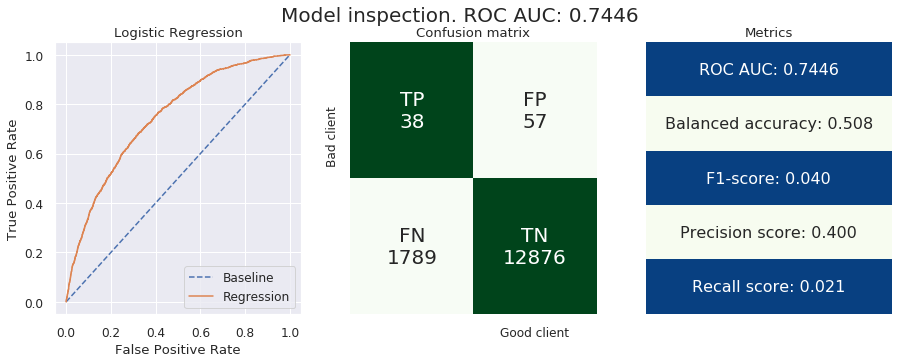

In [76]:
 ModelInspector(model, X_valid, y_valid).inspect()

**Резюме** - На оптимальных гиперпараметрах ситуация изменилась не сильно. Проблема с поиском дефолтных клиентов не решена. 

Есть гипотеза, что корень проблемы лежит в несбалансированности нашей исходной выборки. Один из возможных вариантов решения - это изменить выборку данных: 
 1) oversampling — увеличение кол-ва объектов классов-меньшинств; 
 
 2) undersampling — сокращение кол-ва объектов превалирующих классов.

In [77]:
# Попробуем undersampling и oversampling

over = SMOTE(sampling_strategy=0.5, random_state=RANDOM_SEED)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_SEED)

X_over, y_over = over.fit_resample(X, y)
X_under, y_under = under.fit_resample(X, y)

### Наша модель на несбалансированной выборке:

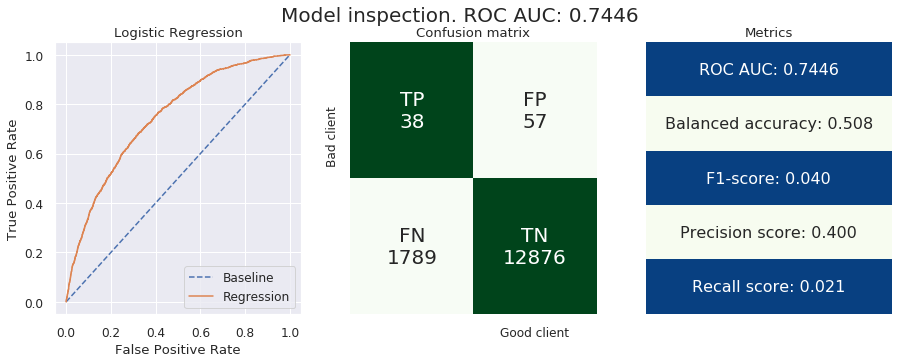

In [78]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

model = LogisticRegression(penalty=best_penalty,
                           C=best_C,
                           solver=best_solver,
                           random_state=RANDOM_SEED)

model.fit(X_train, y_train)
ModelInspector(model, X_valid, y_valid).inspect()

### Наша модель выборке, сбалансированной методом oversampling:

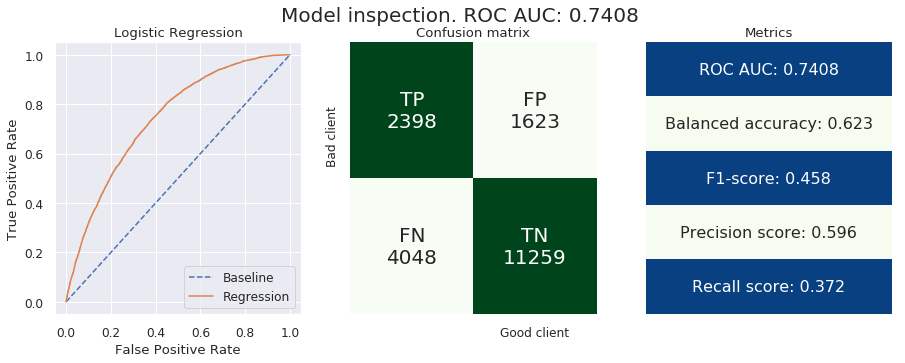

In [79]:
X_train, X_valid, y_train, y_valid = train_test_split(X_over, y_over, test_size=0.20, random_state=42)

model = LogisticRegression(penalty=best_penalty,
                           C=best_C,
                           solver=best_solver,
                           random_state=RANDOM_SEED)

model.fit(X_train, y_train)
ModelInspector(model, X_valid, y_valid).inspect()

### Наша модель выборке, сбалансированной методом undersampling:

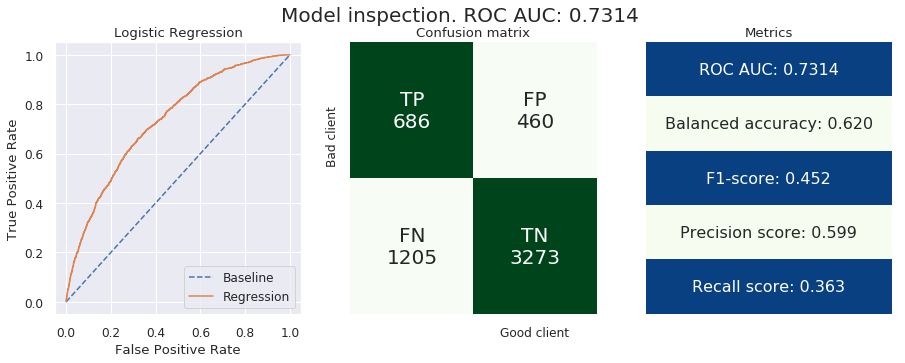

In [80]:
X_train, X_valid, y_train, y_valid = train_test_split(X_under, y_under, test_size=0.20, random_state=42)

model = LogisticRegression(penalty=best_penalty,
                           C=best_C,
                           solver=best_solver,
                           random_state=RANDOM_SEED)

model.fit(X_train, y_train)
ModelInspector(model, X_valid, y_valid).inspect()

**Резюме** - Максимальное значение метрики ROC_AUC при валидации было достигнуто на несбаласированной метрики. Но такую модель использовать неправильно, так как такая моедль плохо ищет дефолтных клиентов, а модель должна работать для бизнеса. 
Выбираем модель обученную на выборке, сбалансированной методом oversampling. Значение метрики ROC_AUC довольно высоко, одновременно с этим занчение метрики f1 также принимает более выгодное значение нежеле чем на несбалансированной выборке.

### Итог:
В результате работы над данными:

 - был произведен разведывательный анализ данных
 - созданы новые признаки
 - отбраны признаки для модели по значимости
 - произведена балансировка классов с помощью undersampling
 - подобраны оптимальные гиперпараметры для модели
 - проведена проверка модели на переобучение - результат отрицательный

В финальной версии модели score -

# 4.Submission

In [81]:
X_train, X_valid, y_train, y_valid = train_test_split(X_over, y_over, test_size=0.20, random_state=42)

model = LogisticRegression(penalty=best_penalty,
                           C=best_C,
                           solver=best_solver,
                           random_state=RANDOM_SEED)

model.fit(X_train, y_train)

LogisticRegression(C=7.742636826811269, random_state=42)

In [82]:
X_test = test_data.drop(['default'], axis=1).values

y_pred_prob = model.predict_proba(X_test)[:,1]

In [83]:
submit = pd.DataFrame(data_test['client_id'])
submit['default'] = y_pred_prob
submit.to_csv('submission.csv', index=False)